# FAST算法提取图像角点

@author Shen Yilin, NJU, 2022

项目特点：

 - 从本地读取图像，转换数据后输入到IP核中计算，最后将输出结果还原为图像显示并保存在out.jpg中
 
 - 双向角点判断（黑-白、白-黑） 
 

## 一、提取并转换图像数据

利用cv库，读取图像，灰度化

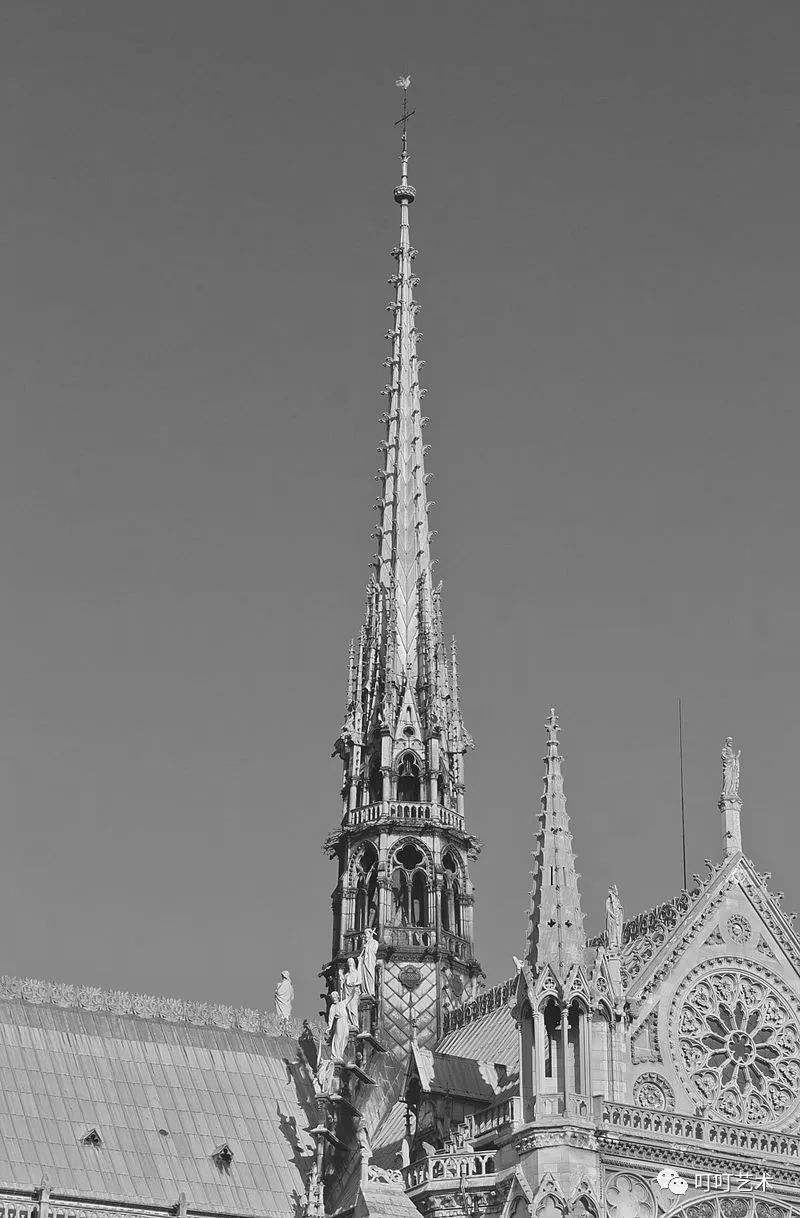

In [107]:
import cv2
import PIL.Image
import numpy as np

img_ori = cv2.imread('./pic/notredame.jpeg', cv2.IMREAD_GRAYSCALE)
#show image
img_gray = PIL.Image.fromarray(img_ori)
img_gray

获取图像行、列数，将图像二维数组展开为一维

In [108]:
img_array = np.array(img_ori)

rows = img_array.shape[0]  #行数
cols = img_array.shape[1]  #列数

img = img_array.flatten()  #数组一维展开

print(len(img))
print(rows)
print(cols)
print(img[0:19])

974400
1218
800
[98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98 98]


## 二、将数据输入IP运算

### 导入overlay

In [109]:
from pynq import Overlay

overlay = Overlay('./FAST.bit')
fast = overlay.fast_accel_0

### 分配buffer和地址

导入allocate，分配输入、输出buffer

 * 由于灰度数据长度仅为1字节，只需分配`i1`类型即可

In [110]:
from pynq import allocate

img_len = len(img)  #图像数据长度
threshold = 20      #阈值

input_buffer = allocate(shape=(img_len,), dtype='i4')
output_buffer = allocate(shape=(img_len,), dtype='i4')

将图像数据拷贝到`input_buffer`中

In [111]:
np.copyto(input_buffer, img)

### 配置IP

将输入参数写入对应的地址空间

In [112]:
fast.s_axi_control.write(0x10, input_buffer.physical_address)  #img_in -> input_buffer
fast.s_axi_control.write(0x1c, output_buffer.physical_address) #img_out -> output_buffer
fast.s_axi_CTRL.write(0x10, threshold)  #threshold
fast.s_axi_CTRL.write(0x18, rows)       #rows
fast.s_axi_CTRL.write(0x20, cols)       #cols

### 启动IP

控制信号位于0x00地址，我们可以对其进行写入与读取来控制IP启动、监听是否完成。

In [113]:
import time

fast.s_axi_CTRL.write(0x00, 0b1)
start_time = time.time()
while True:
    reg = fast.s_axi_CTRL.read(0x00)
    if reg != 1:
        break
end_time = time.time()

print("耗时：{}s".format(end_time - start_time))

耗时：1.0248677730560303s


查看转换后的数组

In [114]:
# print(output_buffer[1000:1099])

一维数组二维重构

In [115]:
#灰度翻转，方便观察
for i in range(img_len):
    if output_buffer[i] == 0:
        output_buffer[i] = 255
    else:
        output_buffer[i] = 0
        
r = np.array(output_buffer)
out_array = r.reshape((rows, cols))
print(out_array)

            

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


图像输出，使用PIL时总是输出纯黑图像，故使用matplot强制作图输出，另外**利用cv库将输出图像保存至本地后，可看出更清晰的角点提取效果**

(-0.5, 799.5, 1217.5, -0.5)

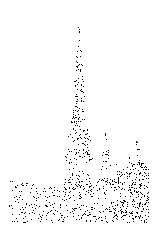

In [116]:
import matplotlib.pyplot as plt
img_out = PIL.Image.fromarray(out_array)
# img_out

plt.imshow(img_out)
plt.axis('off')    #隐藏边框

In [117]:
filepath = "./out.jpg"
cv2.imwrite(filepath, out_array)

True